In [2]:
import h5py
import numpy as np
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.style.use('classic')
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess

from scipy.interpolate import RectBivariateSpline, interp2d
from scipy.ndimage import map_coordinates

import utils

In [3]:
py_directory = "../"
py_directory += "output_travelling_vortex/"

def spatially_averaged_rmse(arr,ref):
    arr = arr[2:-2,2:-2]
    ref = ref[2:-2,2:-2]
    
    arr -= arr.mean()
    ref -= ref.mean()
    
    n,m = ref.shape
    N = n * m
    return np.sqrt(((arr - ref)**2).mean())

def get_filename(grid_x,grid_y,size,end_time,suffix):
    return "output_travelling_vortex_ensemble=" + str(size) + "_" + str(grid_x) + "_" + str(grid_y) + "_" + str(end_time) + suffix + ".h5"

def get_path(filename):
    return py_directory + filename

def py_out(pyfile,py_dataset,time):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

def ensemble_test_case(time, path, N, attribute, label_type='TIME', tag='after_full_step'):
#     inner = (slice(2,-2),slice(2,-2))
    inner = (slice(None,),slice(None,))
    file = h5py.File(path,'r')

    array = []
    for n in range(N):
        if label_type == 'TIME':
#             if N==1:
#                 t_label = '_%.2f_after_full_step' %(time)
#             else:
            t_label = '_ensemble_mem=%i_%.3f_%s' %(n,time, tag)
        elif label_type == 'STEP':
            if N==1:
                t_label = '_%.3d_%s' %(time, tag)
            else:
                t_label = '_ensemble_mem=%i_%.3d_%s' %(n,time, tag)
            
        array.append(py_out(file,attribute,time=t_label)[inner])

    array = np.array(array)
    array = array.mean(axis=0)

    file.close()
    file.close()
    return np.array(array)

def bin_func(obs,ens_mem_shape):
    obs = obs.reshape(ens_mem_shape[0],obs.shape[0]//ens_mem_shape[0],
                      ens_mem_shape[1],obs.shape[1]//ens_mem_shape[1])
    return obs.mean(axis=(1,3))

def rmse(diff):
    return np.sqrt((diff**2).mean())

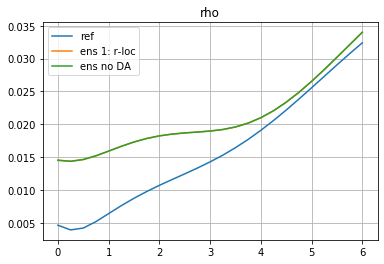

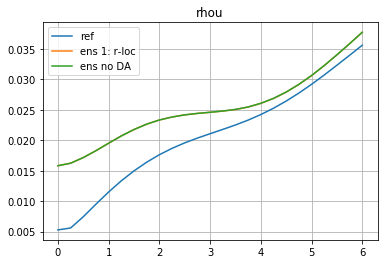

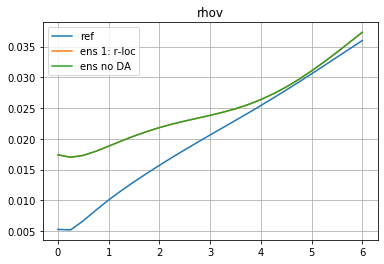

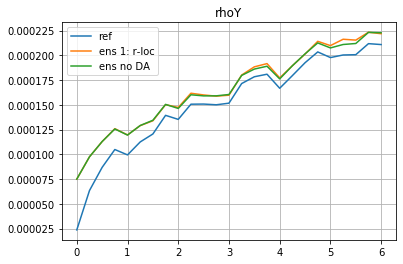

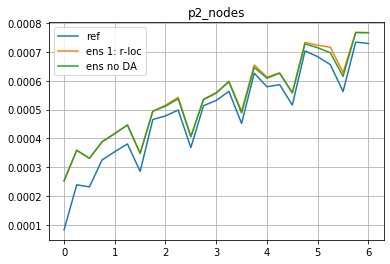

In [4]:
from importlib import reload
import utils
utils = reload(utils)

import plotting_tools as pt
pt = reload(pt)

times = np.arange(0.0,6.01,0.25)
base_fn = "output_travelling_vortex"
py_directory = "../%s/" %base_fn
attributes = ['rho','rhou','rhov','rhoY','p2_nodes']
# attributes = ['p2_nodes']

Nx = 32
Ny = 32
et = 6.0
# p_ref = 8.61 * 1e4

import scipy.ndimage as sciim

tc = utils.test_case(base_fn,py_directory,Nx,Ny,et)
for attribute in attributes:
    
    ref = []
    ref_suffix = 'comp_pp_ref'
    ref.append(tc.get_ensemble(times, 1, attribute, ref_suffix, label_type='TIME'))
    
    ens_noda = []
#     ens_suffix = 'comp_pp_rhos_localised'
    ens_suffix = 'comp_pp_noda'
    ens_noda.append(tc.get_ensemble(times, 10, attribute, ens_suffix, label_type='TIME'))
    
    ens_1 = []
#     ens_suffix = 'comp'
    ens_suffix = 'comp'
#     ens_suffix = 'comp_rloc'
    ens_1.append(tc.get_ensemble(times, 10, attribute, ens_suffix, label_type='TIME'))

    ens_2 = []
    ens_suffix = 'comp_rloc_localisation'
    ens_2.append(tc.get_ensemble(times, 10, attribute, ens_suffix, label_type='TIME'))

    
    truth = []
    truth.append(tc.get_ensemble(times, 1, attribute, 'truthgen', label_type='TIME'))
    
#     if attribute == 'rhov':
#         ens_testp = [[c,t] for c,t in zip(ens_1[0][::2] - truth[0][::2],times[::2])]
#         petp = pt.plotter(ens_testp)
#         petp.plot(figsize=(12,10))

    diff_ens_1 = tc.spatially_averaged_rmse(ens_1[0],truth[0])
    diff_ens_2 = tc.spatially_averaged_rmse(ens_2[0],truth[0])
    diff_noda = tc.spatially_averaged_rmse(ens_noda[0],truth[0])
    diff_ref = tc.spatially_averaged_rmse(ref[0],truth[0])
#     diff3 = tc.spatially_averaged_rmse(cb1[0],psinc[0])

    plt.figure()
    plt.plot(times,diff_ref, label='ref')
    plt.plot(times,diff_ens_1, label='ens 1: r-loc')
#     plt.plot(times,diff_ens_2, label='ens 2: r-loc + localisation')
    plt.plot(times,diff_noda, label='ens no DA')
    plt.title("%s" %attribute)
    plt.grid()
    plt.legend()
    plt.show()

In [5]:
ref_grid_x = 32
ref_grid_y = 32
grid_x = 32
grid_y = 32
ref_size = 1
ens_size_1 = 10
ens_size_2 = 10
end_time = 6.0
print_output = True
print_diffs = True
ens_2 = True

# inner = (slice(2,-2),slice(2,-2))
# inner = (slice(None,),slice(None,))
slc = (slice(2,-2),slice(2,-2))
# slc = (slice(None,),slice(None,))

times = np.arange(0.0,6.1,0.25)

cb1 = [20,20]

attributes = ['rho', 'rhou', 'rhov', 'rhoY', 'p2_nodes']
# attributes = ['rhoY']
# attributes = ['p2_nodes']
fn_suffix = ""

# ens_1_suffix = '_comp_fmp_rhoY_noconv'
ens_1_suffix = '_cont_blend_fs=1_ts=0'
ens_1_suffix = '_comp'

ens_2_suffix = '_comp_noda_pp'
ens_2_suffix = '_comp_fmp_rhoY_noconv'

py_filename_ref = get_filename(ref_grid_x, ref_grid_y, ref_size, end_time, "_truthgen")
py_path_ref = get_path(py_filename_ref)

py_filename_ref_1 = get_filename(grid_x,grid_y,ref_size,end_time, "_comp")
py_path_ref_1 = get_path(py_filename_ref_1)

py_filename_ens_1 = get_filename(grid_x,grid_y,ens_size_1,end_time, ens_1_suffix)
py_path_ens_1 = get_path(py_filename_ens_1)
print(py_filename_ens_1)

if ens_2 == True:
    py_filename_ens_2 = get_filename(grid_x,grid_y,ens_size_2,end_time, ens_2_suffix)
    py_path_ens_2 = get_path(py_filename_ens_2)


for attribute in attributes:
    rmse_ref_1, rmse_ens_1, rmse_ens_2 = [], [], []
    cnt = 0
    for time in times:
        comp_ref = ensemble_test_case(time, py_path_ref,ref_size, attribute, label_type='TIME')
        # print(comp_ref.shape)
        # comp_ref_inner = comp_ref[inner]
        comp_ref_1 = ensemble_test_case(time, py_path_ref_1,ref_size, attribute, label_type='TIME')
        # print(comp_ref_1.shape)
        # comp_ref_1_inner = comp_ref_1[inner]
#         comp_ref = bin_func(comp_ref, comp_ref_1.shape)
        
        # if interpolation_method == "map_coordinates":
        #     x = np.linspace(0,comp_ref_1.shape[0],comp_ref.shape[0])
        #     y = np.linspace(0,comp_ref_1.shape[1],comp_ref.shape[1])

        #     # x = np.linspace(0,comp_ref_1.shape[0]-1,comp_ref.shape[0])
        #     # a = -1
        #     # b = -1
        #     # x = np.arange(comp_ref.shape[0]) / (comp_ref.shape[0] + a) * (comp_ref_1.shape[0] + b)
        #     # y = np.arange(comp_ref.shape[1]) / (comp_ref.shape[1] + a) * (comp_ref_1.shape[1] + b)
        #     # y = np.linspace(0,comp_ref_1.shape[0]-2,comp_ref.shape[1])

        #     x,y = np.meshgrid(x,y)
        #     comp_ref_1 = map_coordinates(comp_ref_1,[y,x],mode=mode,order=order)

        # if interpolation_method == "interp2d":
        #     x = np.linspace(-0.5,0.5,comp_ref_1.shape[0])
        #     y = np.linspace(-0.5,0.5,comp_ref_1.shape[1])

        #     x0 = np.linspace(-0.5,0.5,comp_ref.shape[0])
        #     y0 = np.linspace(-0.5,0.5,comp_ref.shape[1])
        #     mesh = np.array(np.meshgrid(x0,y0))
        #     pts = np.rollaxis(mesh, 0, 3).reshape((-1, 2))
        #     xs_ref = comp_ref.shape[0]
        #     ys_ref = comp_ref.shape[1]
        
        #     comp_ref_1 = interpn((x,y),comp_ref_1,pts, method='linear').reshape(xs_ref,ys_ref).T

        # interpol_ref_1 = RectBivariateSpline(np.linspace(-0.5,0.5,48),np.linspace(-0.5,0.5,48),comp_ref_1)
        # x0 = np.linspace(-0.5,0.5,256)
        # y0 = np.linspace(-0.5,0.5,256)
        # comp_ref_1 =False

        comp_ens_1 = ensemble_test_case(time,py_path_ens_1, ens_size_1, attribute, label_type='TIME')

        # interpol_ens_1 = RectBivariateSpline(np.linspace(-0.5,0.5,48),np.linspace(-0.5,0.5,48),comp_ens_1)
        # x0 = np.linspace(-0.5,0.5,comp_ref.shape[0])
        # y0 = np.linspace(-0.5,0.5,comp_ref.shape[1])
        # comp_ens_1 = interpol_ens_1(x0,y0)

        # if interpolation_method == "map_coordinates":
        #     comp_ens_1 = map_coordinates(comp_ens_1,[y,x],mode=mode,order=order)
        #     # comp_ens_1 = comp_ens_1[inner]
        # if interpolation_method == "interp2d":
        #     comp_ens_1 = interpn((x,y),comp_ens_1,pts, method='linear').reshape(xs_ref,ys_ref).T

        # comp_ref = comp_ref[inner]
        # comp_ref_1 = comp_ref_1[inner]   
        # comp_ens_1 = comp_ens_1[inner]

        rmse_ref_1.append(spatially_averaged_rmse(comp_ref_1,comp_ref))
        rmse_ens_1.append(spatially_averaged_rmse(comp_ens_1,comp_ref))

        if ens_2 == True:
            comp_ens_2 = ensemble_test_case(time, py_path_ens_2, ens_size_2, attribute)
            # if interpolation_method == "map_coordinates":
            #     comp_ens_2 = map_coordinates(comp_ens_2,[y,x],mode=mode,order=order)
                
            # if interpolation_method == "interp2d":
            #     comp_ens_2 = interpn((x,y),comp_ens_2,pts, method='linear').reshape(xs_ref,ys_ref).T

            # comp_ens_2 = comp_ens_2[inner]
            rmse_ens_2.append(spatially_averaged_rmse(comp_ens_2,comp_ref))

        if len(attributes) == 1 and print_output == True:
            nocol = 4 if ens_2 == True else 3
            fig, ax = plt.subplots(ncols=nocol, figsize=(12,5))

            img = ax[0].imshow(comp_ref[slc], origin='lower')
            ax[0].set_title("truth: (%ix%i)" %(ref_grid_x,ref_grid_y))
            img = ax[1].imshow(comp_ref_1[slc], origin='lower')
#             ax[1].set_title("ref: (%ix%i)" %(grid_x, grid_y))
            ax[1].set_title("single run, no DA")
            img = ax[2].imshow(comp_ens_1[slc], origin='lower')
            ax[2].set_title("DA: ens.=%i" %ens_size_1)
            ax[2].set_title("ens. DA (batch obs)")
            if ens_2 == True:
                img = ax[3].imshow(comp_ens_2[slc], origin='lower')
                ax[3].set_title("ens. no DA")
#                 ax[3].set_title("DA: ens.=%i" %ens_size_2)
            fig.colorbar(img, ax=ax, shrink=.5)
            fig.suptitle("time=%.2fs, measurement=%s, ensemble size = 10" %(time,attribute), y=0.8)
            plt.savefig("../output_images/%s_%03d" %(attribute,cnt), bbox_inches='tight')
            plt.show()
            
            if print_diffs == True:
                nocol = 4 if ens_2 == True else 2
                fig, ax = plt.subplots(ncols=nocol, figsize=(12,5))

                diff0 = comp_ens_1[slc] - comp_ref[slc]
                img = ax[0].imshow(diff0, origin='lower')
                ax[0].set_title("ens. 1 - truth \n %.6f" %rmse(diff0))

                diff1 = comp_ens_1[slc] - comp_ref_1[slc]
                img = ax[1].imshow(diff1, origin='lower')
                ax[1].set_title("ens. 1 - single run, no DA\n %.6f" %rmse(diff1))

                if ens_2 == True:
                    diff2 = comp_ens_1[slc] - comp_ens_2[slc]
                    img = ax[2].imshow(diff2, origin='lower')
                    ax[2].set_title("ens. 1 - ens. 2 \n %.6f" %rmse(diff2))
                    
                    diff3 = comp_ens_2[slc] - comp_ref[slc]
                    img = ax[3].imshow(diff3, origin='lower')
                    ax[3].set_title("ens. 2 - truth \n %.6f" %rmse(diff3))

                plt.show()
            
        cnt += 1

    plt.figure(figsize=(8,5))
    plt.plot(times,rmse_ref_1, '-*',label='ref. ' + str(grid_x) + 'x' + str(grid_y) + ' sol')
    plt.plot(times,rmse_ens_1, '-*',label='ens. 1')
    # plt.plot(times,rmse_ens_1, '-*',label='ens. w/o DA, int=0.10')
    if ens_2 == True:
        plt.plot(times,rmse_ens_2, '-*',label='ens. 2')
#         plt.plot(times,rmse_ens_2, '-*',label='ens. with NO DA')
    plt.title("Measurement = %s, ensemble size = %i" %(attribute,ens_size_1))
    plt.xlabel("time")
    plt.ylabel("spatially (and ensemble) averaged RMSE")
    plt.legend(loc='best')
    plt.xticks(times, rotation=45)
    plt.grid()
    plt.savefig("../rmse_" + attribute + fn_suffix + '.png', bbox_inches='tight')
    plt.show()

file = h5py.File(py_directory + py_filename_ens_1, 'r')
if file.__bool__():
    file.close()
if ens_2 == True:
    file = h5py.File(py_directory + py_filename_ens_2, 'r')
    if file.__bool__():
        file.close()

output_travelling_vortex_ensemble=10_32_32_6.0_comp.h5


OSError: Unable to open file (unable to open file: name = '../output_travelling_vortex/output_travelling_vortex_ensemble=1_32_32_6.0_comp.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Truth generator
## A travelling vortex translator

In [ ]:
import scipy.ndimage as sciim
import os

attribute = 'rho'
time = 0
# comp_ref_0 = ensemble_test_case(time, py_path_ref_1,ref_size, attribute,label_type='STEP')
# time = 0.25
# comp_ref_1 = ensemble_test_case(time, py_path_ref_1,ref_size, attribute)

size = 1
grid_x = 32
grid_y = 32
end_time = 6.0
ref_size = size
# suffix = '_truth'
suffix = '_truthgen'

fn = get_filename(grid_x,grid_y,size,end_time,suffix)
print(fn)

path = get_path(fn)
print(path)

fn = get_filename(grid_x,grid_y,size,end_time,'_comp_pp_ref')
py_path_ref_1 = get_path(fn)

fn = get_filename(grid_x,grid_y,size,6.0,'_truthgen')
py_path_ref_2 = get_path(fn)

if os.path.exists(path):
    os.rename(path, path+'_old')
    
file = h5py.File(path, 'a')
attributes = ['rho', 'rhou', 'rhov', 'rhoY', 'Y', 'p2_nodes']
for attr in attributes:
    if not (attr in file):
        file.create_group(attr,track_order=True)
    
file.close()

def roller(arr,n):
    arr = np.roll(arr,n,axis=0)
    arr = np.roll(arr,n,axis=1)
    return arr

# times = np.linspace(0.0,10.0,101*2-1)
# print(times)
# times = [0.0,0.25,0.50,0.75,1.0]
times = np.arange(0.0,6.26,0.005)
steps = range(len(times))
print(steps)
# steps = np.arange(0,321)
# # times = steps / 32
# dt = 1.0 / 32
# times = dt * steps
# print(times)
# print(times)
# print(py_path_ref_1)

# rolled_0 = comp_ref_0.copy()
# rolled_1 = comp_ref_0.copy()

file = h5py.File(path, 'r+')

output_solver = False
print_output = True

# print(py_path_ref_1)
#     print(name)
for attribute in attributes:
    n_step = 0
    comp_ref_0 = ensemble_test_case(0, py_path_ref_1,ref_size, attribute,label_type='TIME')
    rolled_0 = comp_ref_0
    cnt = 0
    
#     name = "ensemble_mem=%i_%.3f_%s" %(0,0,'after_full_step')
#     name = "%.3d_%s" %(0,'after_full_step')
#     file.create_dataset("%s/%s_%s" %(attribute,attribute,name), data=rolled_0, chunks=True, compression='gzip', compression_opts=4, dtype=np.float32)
    for n in steps[:-1]:
        comp_ref_0 = ensemble_test_case(0, py_path_ref_1,ref_size, attribute,label_type='TIME')
        rolled_0 = comp_ref_0
        time = times[cnt]
        name = "ensemble_mem=%i_%.3f_%s" %(0,time,'after_full_step')
#         print(name)
#         name = "%.3d_%s" %(n+1,'after_full_step')
#         print(name)
#         n_step = 65./4 if attribute == 'p2_nodes' else (16.0)
#         n_step = int(n*8.0)
        n_step += (grid_x+1.)/200 if attribute == 'p2_nodes' else (float(grid_x)/200)
        rolled_0 = rolled_0[2:-2,2:-2]
        rolled_0 = np.pad(rolled_0,(1,0),mode='wrap')
        rolled_0 = sciim.shift(rolled_0,n_step, mode='wrap',order=5, prefilter=True)
        rolled_0 = rolled_0[1:,1:]
#         rolled_0 = roller(comp_ref_0[2:-2,2:-2],n_step)
#         rolled_0 = sciim.shift(comp_ref_0[2:-2,2:-2],n_step, mode='wrap')
        rolled_0 = np.pad(rolled_0,2,mode='wrap')
        
        if output_solver == True:
            comp_ref_1 = ensemble_test_case(time, py_path_ref_2,ref_size, attribute, label_type='TIME')
        file.create_dataset("%s/%s_%s" %(attribute,attribute,name), data=rolled_0, chunks=True, compression='gzip', compression_opts=4, dtype=np.float32)
    
# rolled = np.pad(rolled,2,mode='wrap')
        if print_output == True and attribute == 'rho' and n%100==0:
            if output_solver == True:
                fig, ax = plt.subplots(ncols=3, figsize=(9,3))

                ax[0].imshow(comp_ref_1[2:-2,2:-2], origin='lower')
                ax[0].set_title("solver sol.")
                ax[1].imshow(rolled_0[2:-2,2:-2], origin='lower')
                ax[1].set_title("translated sol.")
                im2 = ax[2].imshow(comp_ref_1 - rolled_0, origin='lower')
                ax[2].set_title("difference")
    #             fig.colorbar(im2,ax=ax[2],shrink=0.4)
                fig.colorbar(im2, ax=ax, shrink=.75)
                fig.suptitle("time=%.2f, measurement=%s" %(time,attribute))
                plt.savefig("../output_images/%s_%03d" %(attribute,cnt), bbox_inches='tight')
                plt.show()
            else:
                fig = plt.figure(figsize=(3,3))
                plt.imshow(rolled_0[2:-2,2:-2], origin="lower")
                plt.title("time=%.2f, measurement=%s" %(time,attribute))
                plt.colorbar(shrink=.8)
                plt.show()
                
        cnt += 1
    
file.close()
print("Completed")